# Pneumonia Detection with Chest X-ray Images

## Setup

### Import libraries

In [1]:
import os
from PIL import Image
import random
import sys
from typing import Tuple

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

%matplotlib inline

### Using GPU for training if available

In [2]:
print(f'Python version: {sys.version_info.major}.{sys.version_info.minor}')
print(f'PyTorch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}')

def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    elif torch.backends.mps.is_built():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
        
    return device


device = get_device()
print(f'Using device: {device}')

Python version: 3.11
PyTorch version: 2.0.1
Torchvision version: 0.15.2
Using device: mps


## Exploring the dataset

### Find smallest image size

In [3]:
ROOT_FOLDER = 'dataset/'
TRAINING_FOLDER = f'{ROOT_FOLDER}train/'
VALIDATION_FOLDER = f'{ROOT_FOLDER}val/'
TEST_FOLDER = f'{ROOT_FOLDER}test/'

In [4]:
def find_smallest_image(dataset_root: str) -> Tuple[str, Tuple[int, int]]:
    smallest_width = smallest_height = None
    smallest_filename = ''
    
    for root, _, filenames in os.walk(dataset_root):
        for filename in filenames:
            if filename.endswith(('.jpg', '.png', '.jpeg')):
                path = os.path.join(root, filename)
                with Image.open(path) as image:
                    width, height = image.size
                    if (
                        smallest_width is None
                        or smallest_height is None
                        or width * height < smallest_width * smallest_height
                    ):
                        smallest_width, smallest_height = (width, height)
                        smallest_filename = filename

    return smallest_filename, (smallest_width, smallest_height)


_, smallest_size_training = find_smallest_image(TRAINING_FOLDER)
_, smallest_size_validation = find_smallest_image(VALIDATION_FOLDER)
_, smallest_size_test = find_smallest_image(TEST_FOLDER)
smallest_width, smallest_height = min(
    smallest_size_training, smallest_size_validation, smallest_size_test
)
print(f'{smallest_width}x{smallest_height}')

384x127


### Loading and transforming the files

In [5]:
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
torch.random.manual_seed(RANDOM_SEED);

In [6]:
IMAGE_SIZE = 400
ROTATION_DEGREE = 20

In [7]:
resize = transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE))
to_tensor = transforms.ToTensor()

shared_transforms = [resize, to_tensor]

training_transforms = transforms.Compose([
    resize,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=ROTATION_DEGREE),
    to_tensor
])

In [8]:
# Dataset root URL
# https://ltu.app.box.com/s/ywboito9frcx5w4c4mzrrrl4qf2rh9u3/'

training_dataset = ImageFolder(
    root=TRAINING_FOLDER, transform=training_transforms
)
validation_dataset = ImageFolder(
    root=VALIDATION_FOLDER, transform=transforms.Compose(shared_transforms))
test_dataset = ImageFolder(
    root=TEST_FOLDER, transform=transforms.Compose(shared_transforms))

In [9]:
print(len(training_dataset))
print(len(validation_dataset))
len(test_dataset)

5216
16


624

In [10]:
BATCH_SIZE = 50

In [11]:
training_loader = DataLoader(
    training_dataset, batch_size=BATCH_SIZE, shuffle=True
)
validation_loader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, shuffle=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

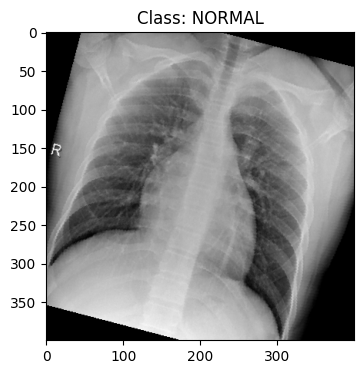

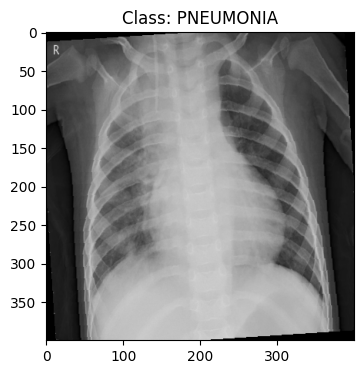

In [12]:
classes = test_dataset.classes

class_id = 0
while class_id < len(classes):
    for images, labels in training_loader:
        for image, label in zip(images, labels):
            if class_id == label:
                plt.figure(figsize=(8, 4))
                plt.title(f'Class: {classes[class_id]}')
                plt.imshow(image.permute(1, 2, 0))
                plt.show()
                
                class_id += 1